# TP Compressed Sensing for MR Images

Diana Mateus



Participants: 

* Yassine Jamoud
* Saâd Aziz Alaoui
* Samy Haffoudhi

### Requirements
Install the required module Sigpy and load modules and functions
    

In [1]:
import numpy as np
import sigpy as sp
import sigpy.plot as pl
import matplotlib.pyplot as plt
from math import log10, sqrt 
from sigpy.mri import poisson, spiral,radial
import sigpy.mri as mr

In [2]:
def multiChannelPhantomKspace(shape =(256,256), nchannels=1):

    #loading the logan phantom
    logan = sp.shepp_logan(shape)

    #copying the fft of the phantom on the different channels
    logan_multi = np.zeros((nchannels,shape[0],shape[1]),dtype=np.complex_)
    logan_multi_ksp = np.zeros((nchannels,shape[0],shape[1]),dtype=np.complex_)
    ksp = sp.fft(logan)
    
    for i in range(nchannels):
        logan_multi[i,:,:]= logan
        logan_multi_ksp[i,:,:]= ksp
    return logan_multi_ksp



In [3]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):    #  MSE is zero means no noise is present in the signal . 
        return -100  #  Therefore PSNR is irrelevant
    max_pixel = original.max()
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr 

## 1. Datasets

### 1.1. K-space

#### a)

In [4]:
#load phantom data

ksp_phantom = multiChannelPhantomKspace(nchannels=1)

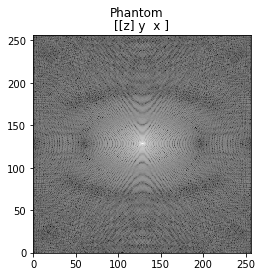

In [5]:
# Visualization

pl.ImagePlot(np.log(np.abs(ksp_phantom)+1e-16), z=0, title='Phantom')

plt.show()

#### b)

In [6]:
# load the in-vivo data
ksp = np.load('cartesian_ksp.npy')

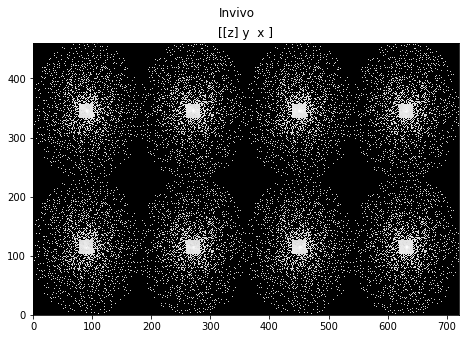

In [7]:
# Visualizing the invivo data
plt.rcParams["figure.figsize"] = (10,5)

# Fill in
pl.ImagePlot(np.log(np.abs(ksp)+1e-16), z=0, title='Invivo')

sample_invivo = np.abs(ksp[0])

#### c)

On observe les signaux bruts fournis par la machine, c'est-à-dire, des transformées de Fourier. Les valeurs correspondent alors à des coefficients de transformée de Fourier. On passe en valeur absolue afin de pouvoir afficher des images et on utilise le log afin d'augmenter la lisibilité.

##  2. Reconstruction of the full phantom data



### 2. Reconstruction of the full phantom data

**2.1.** How do we reconstruct the MRI data from a single fully sampled k-space? 
    
**2.2.** Implement and show the results of reconstructing the **phantom** image from the fully sampled data
    
**2.3.** Compute the wavelet transform of the fully reconstructed image. Why is the wavelet transform a good choice for CS? demonstrate by showing the histogram of the wavelet coefficients ordered from the largest to the smallest.




### 2.1.

Pour la reconstruction, on applique la transformée de fourier inverse.

### 2.2

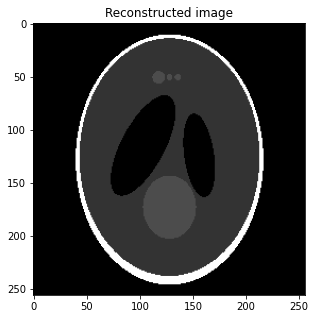

In [8]:
image_recons = np.abs(sp.ifft(ksp_phantom, axes=(-1,-2)))[0]

plt.imshow(image_recons, cmap='gray')
plt.title('Reconstructed image')

plt.show()

### 2.3

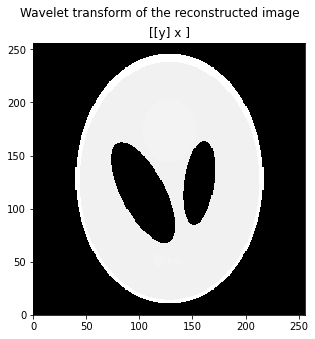

In [9]:
fwt = sp.fwt(image_recons)
fwt_log = np.log(np.abs(image_recons) + 10**-12)

pl.ImagePlot(fwt_log, title='Wavelet transform of the reconstructed image')

La transformée en ondelettes est un choix intéressant pour le CS. En effet, la plupart des coefficients sont nuls (parcimonie). En sachant desquels il s'agit, on peut uniquement acquérier les autres, non nuls.

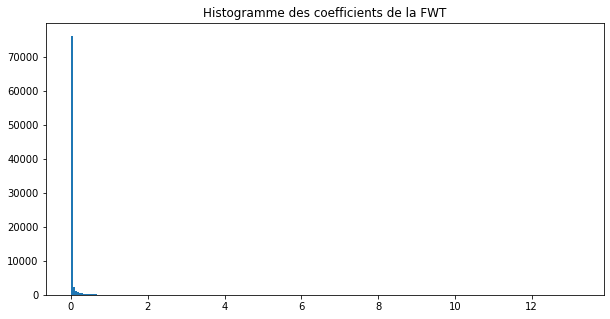

In [10]:
fwt = fwt.flatten()
fwt_sorted = sorted(abs(fwt))[::-1]

plt.hist(fwt_sorted, bins=256)
plt.title('Histogramme des coefficients de la FWT')

plt.show()

On voit que la majorité des coefficients sont effectivement nuls.

## 3. Compressed Sensing on phantom data

### 3.1

Creating mask (./mask_logan_r6_c20.npy)...


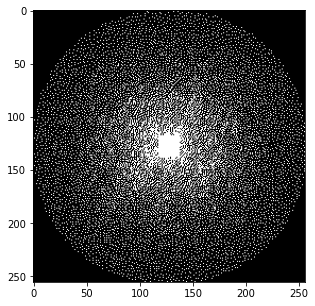

In [11]:
#Example sampling for a single accelerating factor

acc=(6) #Float Target acceleration factor. Must be greater than 1.
shape_calib=20 # Size of the calibration window.
shape_z=ksp_phantom.shape[1]
shape_y=ksp_phantom.shape[2]

random_seed = 42
file_name = './mask_logan_r%0.2g_c%d.npy' % (acc, shape_calib)
print('Creating mask (%s)...' % file_name)

mask = poisson(img_shape=[shape_z, shape_y], accel=acc, 
               max_attempts =15, tol=0.5, 
               calib=(shape_calib, shape_calib))

np.save(file_name, mask.astype(np.complex64))

plt.imshow(np.abs(np.real(mask)),cmap='gray')

plt.show()

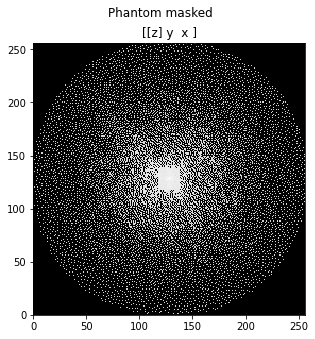

In [12]:
ksp_phantom_masked = ksp_phantom * mask

pl.ImagePlot(np.log(np.abs(ksp_phantom_masked)+1e-16), z=0, title='Phantom masked')

plt.show()

* `acc` permet de jouer sur la dispersion du masque, autrement dit, la quantité de points à l'exterieur du centre.
* `shape_calib` permet de jouer sur la taille du carré central du masque


### 3.3

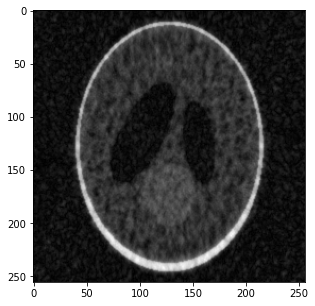

In [13]:
image_recons = np.sum(np.abs(sp.ifft(ksp_phantom_masked, axes=(-1,-2)))**2,axis=0)**0.5

plt.imshow(image_recons, cmap='gray')

plt.show()

On observe des artefacts sur l'image reconstruite causés par l'application du masque qui a mis à zéro plusieurs coefficients de la transformée de fourier.

### 3.4

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

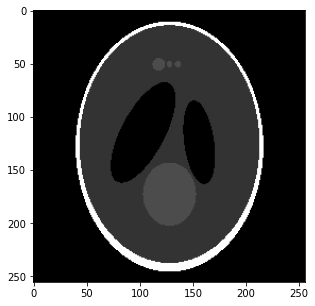

In [14]:
mps_phantom = np.ones((1, 256, 256))
lambda_ = 0.0005
wavelet_recons = sp.mri.app.L1WaveletRecon(ksp_phantom, mps_phantom, lambda_)
img_recons = wavelet_recons.run()

plt.imshow(np.abs(img_recons), cmap='gray')

plt.show()

Le critère optimisé est : 

$$ \frac{1}{2} \lVert PFSx - y \rVert^2_2 + \lambda \lVert Wx \rVert_1 $$

Avec :

* $y$  : kspace
* $P$ : opérateur de sampling
* $F$ : opérateur de transformée en fourier
* $W$ : opérateur de transformée en ondelettes
* $\lambda$ : paramètre de régularisation
* S : opérateur de sensing (matrice contenant que des 1 dans notre cas)

### 3.5

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

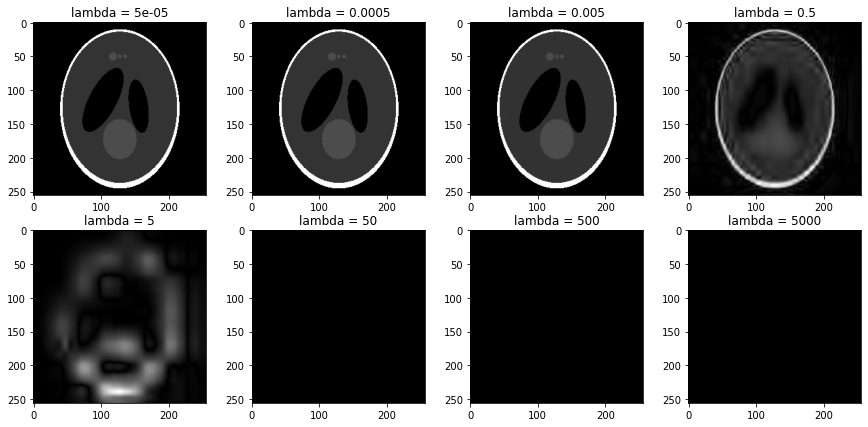

In [15]:
lamda = (0.00005, 0.0005, 0.005,0.5, 5, 50, 500, 5000)
plt.rcParams["figure.figsize"] = (15,7)

for i, l in enumerate(lamda):
    wavelet_recons = sp.mri.app.L1WaveletRecon(ksp_phantom,mps_phantom,l)
    img_recons = wavelet_recons.run()
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.abs(img_recons), cmap='gray')
    plt.title(f"lambda = {l}")
plt.show()

In [16]:
original = np.abs(sp.ifft(ksp_phantom, axes=(-1,-2)))[0]

for lambda_ in lamda:
    wavelet_recons = sp.mri.app.L1WaveletRecon(ksp_phantom,mps_phantom,lambda_)
    compressed = wavelet_recons.run()
    psnr = PSNR(original, compressed)
    print(f"lambda = {lambda_} - PSNR = {psnr}")

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 5e-05 - PSNR = 91.40584957590869


/tmp/ipykernel_161830/3009363345.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  psnr = 20 * log10(max_pixel / sqrt(mse))


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 0.0005 - PSNR = 71.72634258213904


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 0.005 - PSNR = 52.648699372954574


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 0.5 - PSNR = 21.269635133914235


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 5 - PSNR = 13.622074360452235


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 50 - PSNR = 12.131081815228377


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 500 - PSNR = 12.131081815228377


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 5000 - PSNR = 12.131081815228377


On observe alors que $\lambda = 0.0005$ permet de maximiser le PSNR.

### 3.6

On observe ainsi que pour de bonnes valeurs de $\lambda$, la reconstruction à partir du dataset échantillonné est très semblable à celle obtenue à partir du dataset entier. En choisissant une bonne valeur du paramètre de régularisation on peut donc se contenter du dataset échantillonné.

## 4. Compressed Sensing on invivo/brain

### 4.1

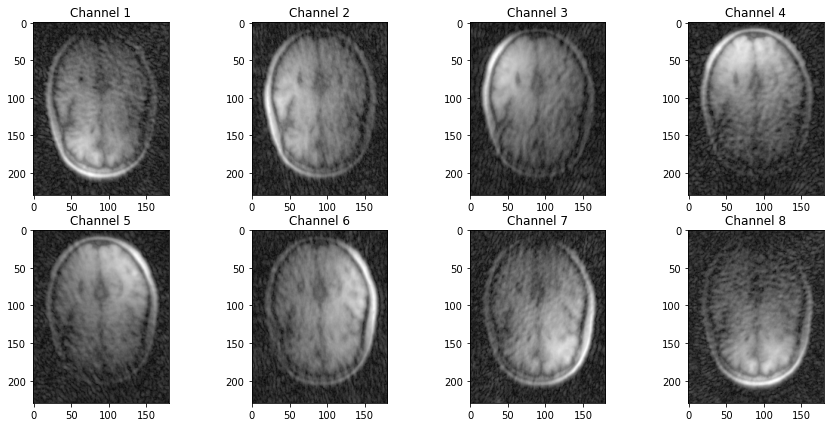

In [17]:
for i in range(8):
    image_recons = np.abs(sp.ifft(ksp[i], axes=(-1,-2)))**0.5
    
    plt.subplot(2, 4, i + 1)
    plt.title(f'Channel {i + 1}')
    plt.imshow(image_recons, cmap='gray')
    
plt.show()

On observe alors que les images obtenues varient entre les différents canaux, il convient alors de combiner ces résultats pour obtenir une unique image.

### 4.2

#### a)

Comme précisé plus haut, la MRI multiparallèle diffère de la MRI traditionnelle puisqu'on disppose de plusieurs canaux dont on peut combiner les reconstructions pour obtenir une unique image reconstruite. On utilise par exemple la RSS pour combiner les reconstructions.

#### b)

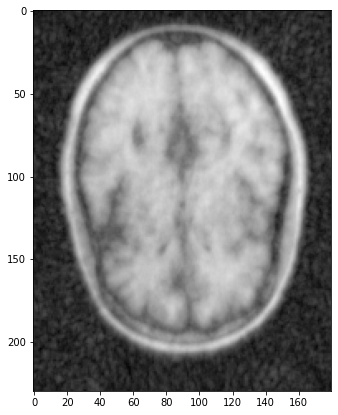

In [18]:
ksp_ifft = sp.ifft(ksp, axes=(-1, -2))
image_recons = np.sum(np.abs(ksp_ifft), axis=0) ** 0.5

plt.imshow(image_recons, cmap='gray')

plt.show()

### 4.3

#### a)

Une sensitivity map $\Phi$ est la matrice qu'on applique aux données à mesurer $x$ :

$$ y = \Phi x $$

Le but des sensitivity maps est de réaliser du compressed sampling.

#### b)

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

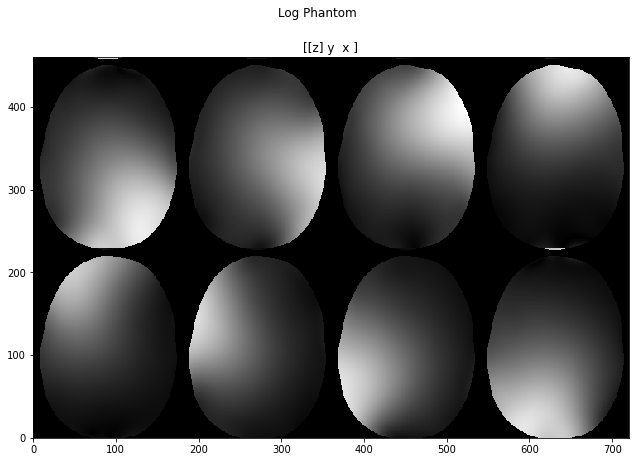

In [23]:
# Sensitivity maps

mps = mr.app.EspiritCalib(ksp).run()

pl.ImagePlot( mps, z=0, title="Log Phantom" )
plt.show()

On observe que ces sensitivity maps sont incohérantes avec les données observées en **1.1.b**.

#### c)

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

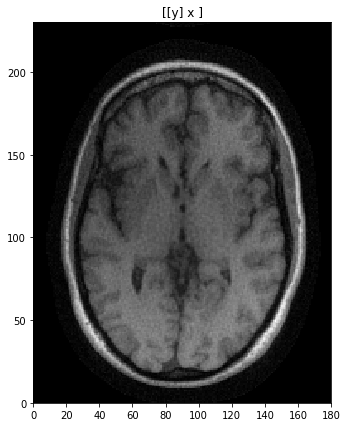

In [25]:
lambda_ = 0.01

image_recons = mr.app.SenseRecon(ksp, mps, lambda_).run()

pl.ImagePlot(image_recons)
plt.show()

#### d)

Le critère optimisé est : 

$$ \frac{1}{2} \lVert PFSx - y \rVert^2_2 + \frac{\lambda}{2} \lVert x \rVert_2^2 $$

Avec :

* $y$  : kspace
* $P$ : opérateur de sampling
* $F$ : opérateur de transformée en fourier
* $\lambda$ : paramètre de régularisation
* $S$ : opérateur de sensing

#### e)

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

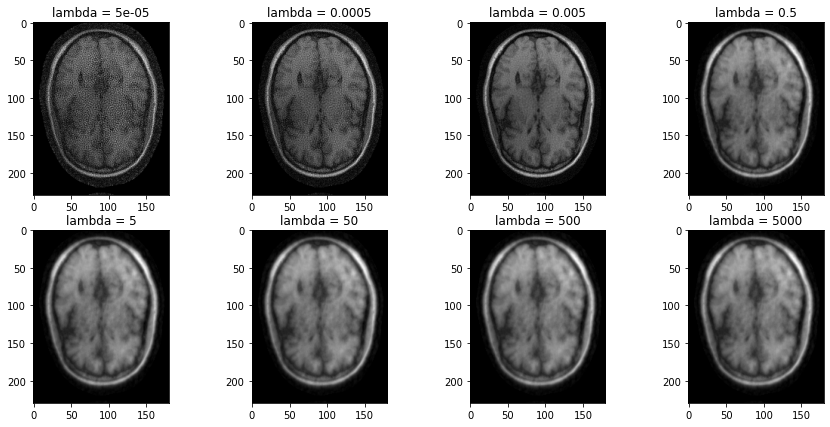

In [27]:
lamda = (0.00005, 0.0005, 0.005,0.5, 5, 50, 500, 5000)
plt.rcParams["figure.figsize"] = (15,7)

for i, l in enumerate(lamda):
    image_recons = mr.app.SenseRecon(ksp, mps, l).run()
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.abs(image_recons), cmap='gray')
    plt.title(f"lambda = {l}")
plt.show()

On observe que le paramètre $\lambda$ impacte la reconstruction. 
Ce terme gère l'importance du terme $ \lVert x \rVert_2^2 $.
Pour des valeurs de $\lambda$ trop élevées on obtient une image floue tandis que pour des valeurs trop faibles, l'image est bruitée.

### 4.4

#### a)

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

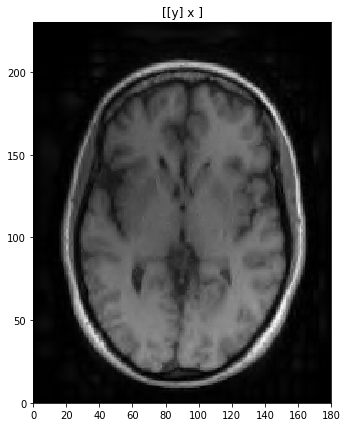

In [30]:
lambda_ = 0.01

image_recons = mr.app.L1WaveletRecon(ksp, mps, lambda_).run()

pl.ImagePlot(image_recons)
plt.show()

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

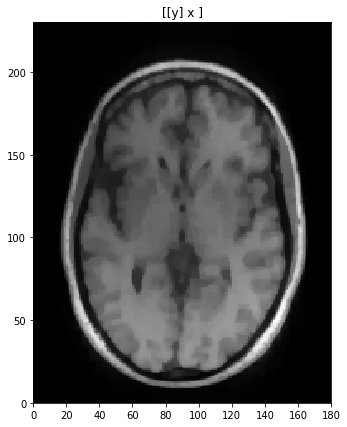

In [31]:
lambda_ = 0.01

image_recons = mr.app.TotalVariationRecon(ksp, mps, lambda_).run()

pl.ImagePlot(image_recons)
plt.show()

#### b)

Pour `L1WaveletRecon`, Le critère optimisé est : 

$$ \frac{1}{2} \lVert PFSx - y \rVert^2_2 + \lambda \lVert Wx \rVert_1 $$

Avec :

* $y$  : kspace
* $P$ : opérateur de sampling
* $F$ : opérateur de transformée en fourier
* $W$ : opérateur de transformée en ondelettes
* $\lambda$ : paramètre de régularisation
* S : opérateur de sensing

Pour `L1WaveletRecon`, Le critère optimisé est : 

$$ \frac{1}{2} \lVert PFSx - y \rVert^2_2 + \lambda \lVert Gx \rVert_1 $$

Avec :

* $y$  : kspace
* $P$ : opérateur de sampling
* $F$ : opérateur de transformée en fourier
* $G$ : gradient
* $\lambda$ : paramètre de régularisation
* S : opérateur de sensing (matrice contenant que des 1 dans notre cas)

#### c)

##### L1WaveletRecon

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

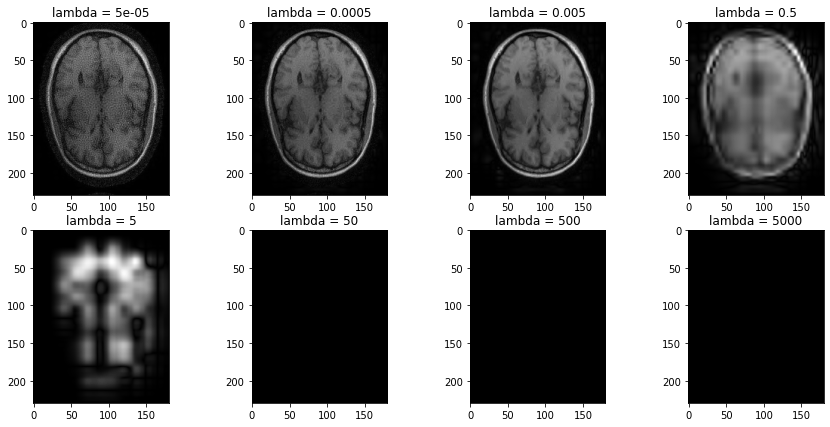

In [32]:
lamda = (0.00005, 0.0005, 0.005,0.5, 5, 50, 500, 5000)
plt.rcParams["figure.figsize"] = (15,7)

for i, l in enumerate(lamda):
    image_recons = mr.app.L1WaveletRecon(ksp, mps, l).run()
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.abs(image_recons), cmap='gray')
    plt.title(f"lambda = {l}")
plt.show()

Le paramètre de régularisation $\lambda$ gère l'importance du terme $ \lVert Wx \rVert_1 $.

##### TotalVariationRecon

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

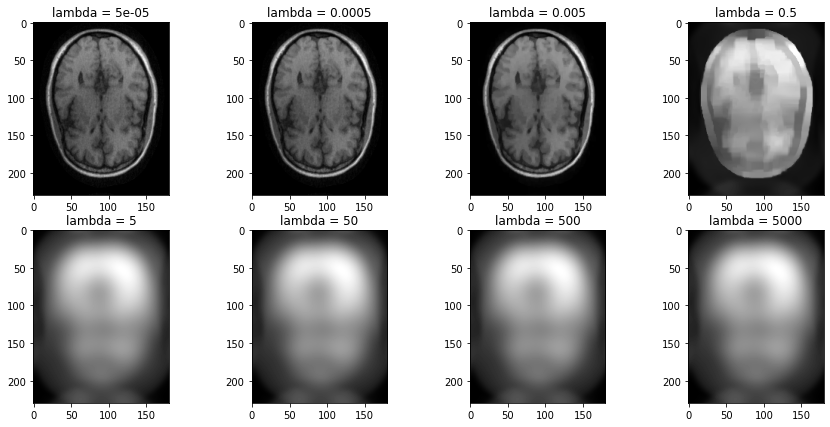

In [33]:
lamda = (0.00005, 0.0005, 0.005,0.5, 5, 50, 500, 5000)
plt.rcParams["figure.figsize"] = (15,7)

for i, l in enumerate(lamda):
    image_recons = mr.app.TotalVariationRecon(ksp, mps, l).run()
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.abs(image_recons), cmap='gray')
    plt.title(f"lambda = {l}")
plt.show()

Le paramètre de régularisation $\lambda$ gère l'importance du terme $ \lVert Gx \rVert_1 $.
Ainsi, pour les valeurs élevées de $\lambda$ favorisent les images avec de faibles variations. 

## Conclusion

Pour conclure, lors de ce TP nous avons pu mettre en application le compressed sensing à a reconstruction IRM.
Nous avons travaillé sur deux datasets (un unique chanel et un multichanel) et nous avons premièrement obtenu les images reconstruites par transformée de fourier inverses. Nous avons ensuite pu implémenter différentes méthodes de CS (totalvariance, transformée en ondelette) à l'aide de la librairie `sigpy` afin de les comparer aux reconstructions obtenues à partir des datasets entiers.
Nous avons alors pu prendre conscience de l'utilité de telles méthodes et de l'importance du choix du paramètre de régularisation.